<a href="https://colab.research.google.com/github/sgr1118/GD-NLP-Theory/blob/main/GD8_Translate_with_Seq2seq(221008).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8-1. Seq2seq 기반 번역기 만들기

이전 시간에 seq2seq 구조를 배웠다. 두 개의 RNN 모듈을 Encoder - Decoder 구조로 결합하여 사용하는 seq2seq는 혁신적이었다.

이번 GD8에서는 seq2seq를 활용하여 직접 번역기를 만들어본다. 그리고 Attention 기법을 추가하여 성능을 높여보기로 한다.

실습 데이터에는 영어-스페인어 말뭉치를 사용하고 프로젝트는 한국어-영어 말뭉치를 사용한다.

In [ ]:
# 사전 준비 - 한글 폰트 설치하기
# 설치 후 런타임 다시 시작 필수

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (17.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

# 8-2. 데이터 전처리

1. 데이터 준비하기

In [ ]:
# 필요한 라이브러리 불러오기

import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.8.2


데이터를 다운로드하는 데에는 텐서플로우에서 제공하는 tf.keras.utils.get_file() 함수를 사용할 겁니다. get_file()함수는 URL로부터 데이터를 다운받고, 압축된 형식일 경우 해제까지 알아서 할 수 있는 똑똑한 함수랍니다! 아래 소스를 실행해 데이터를 다운로드받아주세요.

In [ ]:
# 데이터 불러오기

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [ ]:
# 데이터 형태 확인

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


2. 데이터 전처리 : 정제하기

데이터는 \t 기호를 기준으로 영어와 스페인어가 병렬 쌍을 이루고 있습니다. 고로 \t 기호를 매개변수 split() 함수를 호출하면 손쉽게 소스 문장과 타겟 문장을 분리할 수 있다.

추가로 위 예시에서 ¡같은 기호가 포함되어있어 이 같은 특수 문자는 불필요한 노이즈로 작용할 수 있기 때문에 정제 과정에서 삭제하도록 한다.

사실 스페인에서는 역 물음표(¿)와 역 느낌표(¡)를 일반적으로 사용합니다. 문장이 물음표나 느낌표로 끝난다면 해당 문장 맨 앞에 역으로 된 기호를 붙여준다고 해요. 이해를 돕기 위해 이상한 기호 취급을 하였으니 양해를 바랍니다!


In [ ]:
# 전처리 코드

def preprocessing_sentence(sentence, s_token=False, e_token=False):
  sentence = sentence.lower().strip()

  sentence = re.sub(r'([?.!,])', r' \1', sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

  sentence = sentence.strip()

  if s_token:
    sentence = '<start> ' + sentence

  if e_token:
    sentence += ' <end>'

  return sentence

전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다. 이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 이전 렉처 노드에서 살펴보았듯, Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하기 때문입니다.

원활한 학습을 위해 데이터는 상위 3만 개만 사용하도록 하겠습니다.

In [ ]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
  eng, spa = pair.split('\t')

  enc_corpus.append(preprocessing_sentence(eng))
  dec_corpus.append(preprocessing_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


3. 데이터 전처리 : 토큰화

정제된 텍스트를 아래 tokenize() 함수를 사용해 토큰화하고 텐서로 변환하세요. 그리고 변환된 텐서를 80%의 훈련 데이터와 20%의 검증 데이터로 분리하세요! (Tokenizer의 단어 수는 자유롭게 진행하세요!)

In [ ]:
def tokenize(corpus):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(corpus)

  tensor = tokenizer.texts_to_sequences(corpus)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')

  return tensor, tokenizer

In [ ]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size = 0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4934
Spanish Vocab Size: 8895


# 8-3. 모델 설계

이제부터 아래 그림처럼 각각 1개의 GRU을 갖는 Encoder-Decoder 구조를 설계할 겁니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GN-4-P-2.max-800x600.jpg)
<center>GRU 구조</center>

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 tStep의 Hidden Stae를 만들어 냅니다.

Decoder에서 tStep의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생선된 tStep의 Hidden State는 t+1 Step의 Hidden state를 만들기 위해 다시 Decoder에 전달됩니다.

여기서 't=1일 때의 Hidden State는 어떻게 정의할 것인가?'가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

Attention은 Bahdanau를 사용하고 위에서 작성한 코드를 그대로 가져다쓴다.

[Bahdanau Attention 위키독스](https://wikidocs.net/73161)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.w_dec = tf.keras.layers.Dense(units)
    self.w_enc = tf.keras.layers.Dense(units)
    self.w_com = tf.keras.layers.Dense(1)

  def call(self,h_enc, h_dec):
    # h_enc shape: [batch x length x units]
    # h_dec shape: [batch x units]

    h_enc = self.w_enc(h_enc)
    h_dec = tf.expand_dims(h_dec, 1)
    h_dec = self.w_dec(h_dec)

    score = self.w_com(tf.nn.tanh(h_dec + h_enc))

    attn = tf.nn.softmax(score, axis=1)

    context_vec = attn * h_enc
    context_vec = tf.reduce_sum(context_vec, axis=1)

    return context_vec, attn

위 그림과 동일한 구조를 갖는 Encoder 클래스와 Decoder 클래스를 설계하기

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()

    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

  def call(self, x):
    out = self.embedding(x)
    out = self.gru(out)

    return out

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True,
                                   return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

  def call(self, x, h_dec, enc_out):
    context_vec, attn = self.attention(enc_out, h_dec)

    out = self.embedding(x)
    out = tf.concat([tf.expand_dims(context_vec, 1), out], axis = -1)

    out, h_dec = self.gru(out)
    out = tf.reshape(out, (-1, out.shape[2]))
    out = self.fc(out)

    return out, h_dec, attn

In [ ]:
#실행하여 결과 확인해보기

BATCH_SIZE = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))

sample_output = encoder(sample_enc)

print('Encoder Output : ', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output :  (64, 30, 1024)
Decoder Output: (64, 8896)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


tf.random.uniform()에 대한 간단한 설명

- tf.random.uniform()는 난수를 생성하기위해 사용된다.

- tf.random.uniform()안에 shape, minval, maxval, dtype, seed, name가 들어갈 수 있다.

자세한 설명은 tesorflow 공식 사이트 참고

[tensorflow uniform](https://www.tensorflow.org/api_docs/python/tf/random/uniform)




# 8-4. 훈련하기 (1) Optimizer & Loss

지금까지는 fit() 함수로 간편하게 학습을 진행했지만, Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 학습 과정을 직접 정의해줘야 합니다. 조금 불편하고 난감하게 다가올 수도 있지만 후에 더 멋진 연구를 하기 위한 발판이 되어 줄 테니 익숙해져 봅시다!

낯선 함수들이 지나치게 많이 등장할 수 있으니, 이번 코스에선 직접 구현을 하기보단 구현체를 먼저 보고 이해하는 방향으로 공부하도록 합시다!


1. Optimizer & Loss

Optimizer와 Loss에서 fit()을 사용하지 않는 이유는 Loss함수 때문이다. Encoder - Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야한다.

SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (원-핫이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구한다. 

CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 것이다.

from_logits는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정한다. 아래에서 True로 줬으니 모델의 출력값을 그대로 전달하면된다.

데이터를 한 번에 처리하기 위해 가장 긴 문장을 기준으로 패딩 과정을 거친다. tokenize() 함수 내부의 pad_sequences()가 바로 그 역할을 하였다.

만약 모델에게 <PAD> 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 데이터의 굉장히 많은 부분이 <PAD>로 이뤄져 있다고 생각하게 된다. 쉽게 말해 유난히 같은 답이 많은 객관식 시험이라고 생각한다.

모델은 심지어 10000개의 정답이 넘게 있는 고난도의 문제를 풀고 있기에 패딩에 대한 처리를 해주지 않으면 <PAD>토큰만을 생성할 확률이 굉장히 높아진다.

이것은 종종 발생하는 문제라서 기억해두고 향후 연구에서 활요하면 좋다. 그리고 이 문제를 방지하기 위해 mask가 사용된다.

mask는 정답지에서 <PAD>토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 한다. equal()함수에 정확히는 0이 아닌 <PAD>토큰의 인덱스를 전달하는 것이 맞지만 대부분의 경우는 0으로 패딩되기 때문에 편의상 0을 전달하여 처리하도록 한다.


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype = loss.dtype)
  loss *= mask # *=는 왼쪽 변수에 오른쪽 값을 곱하고 그 결과를 왼쪽 변수에 할당한다.
  # 예시로 a *= b는 a = a*b를 의미함.

  return tf.reduce_mean(loss)

# 8-5. 훈련하기 (2) train_step 구현하기

train_step()의 학습 과정

1. Encoder에 소스 문장을 전달해 context_vec인 enc_out을 생성

2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]

3. Decoder에 입력으로 전달한 <start>토큰 문장 생성

4. <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred

5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예츠 단어 X)

6. 반복

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
  bsz = src.shape[0]
  loss = 0 

  with tf.GradientTape() as tape:
    enc_out = encoder(src)

    # t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의.
    h_dec = enc_out[:, -1] # 각 원소에서 맨 마지막 출력
    
    # Decoder에 입력으로 전달할 <start> 토큰 문장 생성
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    # <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. 
    for t in range(1, tgt.shape[1]):
      pred, h_dec,_ = decoder(dec_src, h_dec, enc_out)

      loss += loss_function(tgt[:, t], pred) # 각 원소에서 t번째 출력하여 loss함수에 삽입
      dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss / int(tgt.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문이죠! 실제로 위 예제에서 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요된답니다! 그러니 가능하다면 사용하는 쪽이 유리하겠죠? 아래는 @tf.function의 공식 문서입니다.

[텐서플로 2.0의 tf.function과 오토그래프 (AutoGraph) | TensorFlow Core](https://www.tensorflow.org/guide/function?hl=ko)

tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프입니다. 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됩니다. 이 또한 공식 문서를 첨부해드릴게요!

[그래디언트 및 자동 미분 소개 | TensorFlow Core](https://www.tensorflow.org/guide/autodiff?hl=ko)

In [ ]:
# [:, -1] 예시
a = [[0, 1, 2], [3, 4, 5]]
a = np.array(a)
a[:, -1]

array([2, 5])

# 8-6. 훈련하기 (3) 훈련 시작하기

In [ ]:
from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                            dec_train[idx:idx+BATCH_SIZE],
                            encoder, decoder, optimizer, dec_tokenizer)
    
    total_loss += batch_loss

    t.set_description_str('Epoch %2d' % (epoch + 1)) # # tqdm
    t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

Epoch 10: 100%|██████████| 375/375 [00:14<00:00, 25.54it/s, Loss 0.1392]


먼저 EPOCHS = 10 만큼 반복하는 루프에 진입한 후, 각 배치의 시작 인덱스를 idx_list 배열에 저장한다. 그리고 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어줘야 한다.

이 과정은 인덱스를 섞어서 처리할 것이다. 순차적인 인덱스를 데이터로 불러오는 게 아닌 랜덤한 인덱스로 데이터를 불러오는 것은 데이터를 불러오는 것은 데이터를 섞는 것과 동일한 효과를 가져온다.

그 후에 각 미니배치를 train_step() 함수에서 학습한다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수였다.

1. 실습하기

Step 1에서 분리한 Validation Set을 사용하는 eval_step() 함수를 정의하세요! 그리고 train_step() 을 마친 후, 곧이어 eval_step() 을 진행하도록 소스를 수정하세요! 결과는 아래와 같은 형태가 되어야 합니다.

In [ ]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기

# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  loss = 0 

  enc_out = encoder(src)

  # t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의.
  h_dec = enc_out[:, -1] # 각 원소에서 맨 마지막 출력
    
  # Decoder에 입력으로 전달할 <start> 토큰 문장 생성
  dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

  # <start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. 
  for t in range(1, tgt.shape[1]):
    pred, h_dec,_ = decoder(dec_src, h_dec, enc_out)

    loss += loss_function(tgt[:, t], pred) # 각 원소에서 t번째 출력하여 loss함수에 삽입
    dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss / int(tgt.shape[1]))

  return batch_loss

# Training Process

from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                            dec_train[idx:idx+BATCH_SIZE],
                            encoder, decoder, optimizer, dec_tokenizer)
    
    total_loss += batch_loss

    t.set_description_str('Epoch %2d' % (epoch + 1)) # # tqdm
    t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

  test_loss = 0

  idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (test_batch, idx) in enumerate(t):
    test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                            dec_val[idx:idx+BATCH_SIZE],
                            encoder, decoder, dec_tokenizer)
    
    test_loss += test_batch_loss

    t.set_description_str('Test Epoch %2d' % (epoch + 1))
    t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 94/94 [00:01<00:00, 53.77it/s, Test Loss 0.7636]


Input: can i have some coffee ?
Predicted translation: me das un poco ? <end> 


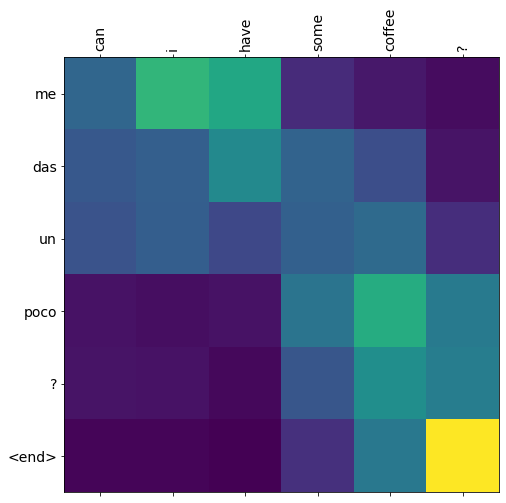

In [ ]:
# Attention Map 시각화

def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))

  sentence = preprocessing_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(
      inputs, maxlen = enc_train.shape[-1], padding='post')
  
  result = ''

  enc_out = encoder(inputs)

  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '
    
    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention, cmap = 'viridis')

  fontdict = {'fontsize' : 14}

  ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence, encoder, decdoer):
  result, sentence, attention = evaluate(sentence, encoder, decdoer)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))

translate("Can I have some coffee?", encoder, decoder)